# Test routines for calculating internal wave properties 

Calculate the following properties from the buoyancy frequency:

 - Vertical mode function
 - Linear phase speed (rotating frame)
 - Alpha (nonlinearity)
 - Beta (dispersion)
 - Ratio of sea-surface displacement to internal displacement
 
 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr

import iwatlas.stratification as strat
from iwatlas import iwaves
from iwatlas import sshdriver

In [2]:
############
basedir = '/home/suntans/cloudstor/Data/IWAtlas-lite'


# climfile = '{}/NWS_2km_GLORYS_hex_2013_2014_Climatology.nc'.format(basedir)
N2file = '{}/NWS_2km_GLORYS_hex_2013_2014_Stratification_Atlas.nc'.format(basedir)

# Test points
xpt = np.array([120.5,122.1])
ypt = np.array([-12.,-12.])

timept = np.array([np.datetime64('2013-07-01 00:00:00'), 
                   np.datetime64('2013-11-01 00:00:00'),
                   np.datetime64('2014-03-01 00:00:00')])

Nz = 80

###########

print('Calculating densty stratification data...')

# N2_t = strat.predict_N2_params(N2file, xpt, ypt, timept )
N2_z, zout = strat.predict_N2(N2file, xpt, ypt, timept,  Nz)

Calculating densty stratification data...


In [4]:

phi_n, cn = iwaves.calc_modes(N2_z, zout)
alpha = iwaves.calc_alpha(phi_n, cn, zout)
beta = iwaves.calc_beta(phi_n, cn, zout)
ampratio = iwaves.ssh_to_amp_ratio(N2_z, phi_n, zout)
sshratio = iwaves.amp_to_ssh_ratio(N2_z, phi_n, zout)

sshratio

masked_array(
  data=[[316.41451515, 319.67965585, 374.55802821],
        [229.12618725, 250.65093379, 249.9787156 ]],
  mask=False,
  fill_value=1e+20)

---
# Testing

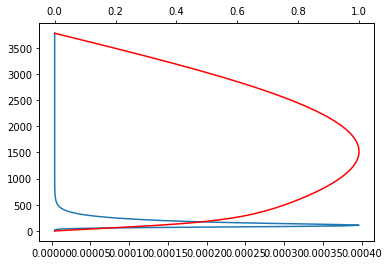

In [9]:
phi, c = iwaves.iwave_modes(N2[:,0,0], zout[:,0,0])

plt.figure()
plt.plot(N2_z[:,0,0], zout[:,0,0])
plt.twiny()
plt.plot(phi[:,0], zout[:,0,0],'r')


# Internal tide parameter

SSH to internal tide amplitude ratio

See Zhao 2016 Eq. A8

$$
\frac{SSH}{a_0} = \frac{1}{g}\int_{-H}^0 \phi(z)N^2(z)dz
$$

In [56]:
def calc_alpha(phi, c, z):
    phi_z = grad_z(phi_n, -z)
    num = 3*c*np.trapz( np.power(phi_z,3.), z, axis=0)
    den = 2*np.trapz(np.power(phi_z,2), z, axis=0)
    return num/den

def calc_beta(phi, c, z):
    phi_z = grad_z(phi_n, -z)
    num = c*np.trapz( np.power(phi_n, 2.), z, axis=0)
    den = 2*np.trapz( np.power(phi_z, 2.), z, axis=0)
    
    return num/den

def ssh_to_amp_ratio(N2, phi, z):
    """
    SSH to internal tide amplitude ratio
    
    See Zhao 2016 Eq. A8
    
    $$
    \frac{SSH}{a_0} = \frac{1}{g}\int_{-H}^0 phi(z)N^2(z)dz
    $$
    """
    grav=9.81
    
    return 1/grav * np.trapz(phi*N2, z, axis=0)
    
def amp_to_ssh_ratio(N2, phi, z):
    
    return np.power(ssh_to_amp_ratio(N2, phi, z), -1.)


# Calcultaae
def calc_alpha_1d(phi, c, dz):
    phi_z = np.gradient(phi,-dz)
    num = 3*c*np.trapz( phi_z**3., dx=dz)
    den = 2*np.trapz( phi_z**2., dx=dz)

    return num/den

def calc_beta_1d(phi, c, dz):
    phi_z = np.gradient(phi, dz)
    num = c*np.trapz( phi**2., dx=dz)
    den = 2*np.trapz( phi_z**2., dx=dz)

    return num/den



In [57]:
def calc_modes(N2, z, mode=0):
    """
    Wrapper for iwaves uneven mode calculation
    """    
    
    sz = N2.shape
    nx = int(np.prod(sz[1:]))

    # Need to reshape so rows contain time and other dimensions are along the columns
    N2 = np.reshape(N2,(sz[0], nx))
    z = np.reshape(z,(sz[0], nx))
    
    phi_n = np.zeros_like(N2)
    cn = np.zeros((nx,))

    for ii in range(nx):
        phi, c = iwaves.iwave_modes_uneven(N2[:,ii], z[:,ii])
        phi_n[:, ii] = phi[:, mode]
        cn[ii] = c[mode]
        
    return np.reshape(phi_n, sz), np.reshape(cn, sz[1:])

phi_n, cn = calc_modes(N2_z, zout)
alpha = calc_alpha(phi_n, cn, zout)
beta = calc_beta(phi_n, cn, zout)
ampratio = ssh_to_amp_ratio(N2_z, phi_n, zout)
sshratio = amp_to_ssh_ratio(N2_z, phi_n, zout)


zout[-1,...], cn, alpha, beta, ampratio, sshratio

# N2_da = xr.DataArray(N2_z, dims=('depth','space','time')).chunk({'depth':-1,'space':1,'time':1})
# zout_da = xr.DataArray(N2_z, dims=('depth','space','time')).chunk({'depth':-1,'space':1,'time':1})


# xr.apply_ufunc(calc_modes, N2_da, zout_da,
#              input_core_dims=[['space','time'], ['space','time']],
#              exclude_dims=set(('space','time')),
#                dask='allowed'
#               )

(masked_array(
   data=[[3776.8331469164414, 3776.8331469164414, 3776.8331469164414],
         [1506.633945650305, 1506.633945650305, 1506.633945650305]],
   mask=[[False, False, False],
         [False, False, False]],
   fill_value=1e+20),
 array([[2.81040228, 2.78908038, 2.97124306],
        [2.2934462 , 2.36330206, 2.32528942]]),
 masked_array(
   data=[[-0.007554582101694005, -0.0076130343702253125,
          -0.003350052430232455],
         [-0.01802240276308202, -0.013724545576055602,
          -0.014464985329107838]],
   mask=[[False, False, False],
         [False, False, False]],
   fill_value=1e+20),
 masked_array(
   data=[[1328098.8526029198, 1298329.328202896, 1822926.2160515438],
         [129684.20596074034, 160615.53724621743, 153865.0532928526]],
   mask=[[False, False, False],
         [False, False, False]],
   fill_value=1e+20),
 masked_array(
   data=[[0.003160411271004438, 0.003128131495681573,
          0.0026698132857363647],
         [0.0043644072814598344, 0.

# Testing...

12.0

In [4]:
# Calculate the depth at the sites of interest
sun = sshdriver.load_ssh_clim(N2file)
sun

<xarray.Dataset>
Dimensions:  (Nc: 225368, Nk: 80, Nkw: 81, Nmode: 4, Np: 454016, Nparams: 6, Ntide: 4, numsides: 8, time: 23)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-16 2013-07-31 ... 2014-06-11
    xv       (Nc) float64 ...
    yv       (Nc) float64 ...
    Nk       (Nc) int32 ...
    z_w      (Nkw) float64 ...
    omega    (Ntide) float64 ...
    params   (Nparams) int64 ...
Dimensions without coordinates: Nc, Nkw, Nmode, Np, Nparams, Ntide, numsides
Data variables:
    cells    (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    xp       (Np) float64 1.394e+07 1.271e+07 1.517e+07 ... 1.303e+07 1.303e+07
    yp       (Np) float64 -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
    nfaces   (Nc) int32 ...
    dv       (Nc) float64 ...
    modes    (Nmode) float64 ...
    dz       (Nk) float64 ...
    z_r      (Nk) float64 ...
    N2_t     (time, Nparams, Nc) float64 ...
    N2_mu    (Nparams, Nc) float64 ...
    N2_re    (Ntide, Nparams, Nc) float64 .

In [46]:
### Code to generate the vertical grid (s-coordinate grid)
def calc_scoord_log(Nz, rfac):
    s0 = (rfac-1)/(np.power(rfac, Nz-1)-1)
    scoord = np.zeros((Nz,))
    scoord[1] = s0
    for ii in range(2,Nz):
        scoord[ii] =  scoord[ii-1]*rfac

    return np.cumsum(scoord)

def return_zcoord_3d(sun, xpt, ypt, nt, nz, scoord=None, rfac=1.04):
    """
    Create a vertical grid array
    
    Inputs:
    ---
        N2file: filename of the stratification climatology dataset (NWS_2km_GLORYS_hex_2013_2014_Stratification_Atlas.nc)
        xpt,ypt: vectors [nx] of output space points
        nt: scalar, number of time points
        nz: scalar, number of vertical layers
        scoord: (optional) vector nx, locations of vertical nodes in non-dimensional space i.e. between 0 and 1
        rfac: (optional) scalar 1 to 1.1 logarithmic scaling factor for the vertical coordinate
    
    Returns:
        zout: array of buoyancy frequency [nz, nx, nt]
    """
    # Get the depths
    h = sun.interpolate(sun._ds.dv, xpt, ypt)

    nt = timept.shape[0]

    hgrd = h[:,None] * np.ones((nt,))[None,:]
    
    if scoord is None:
        scoord = calc_scoord_log(Nz, rfac)

    return scoord[:,None,None] * hgrd[None, ...]



In [47]:
zout = return_zcoord_3d(sun, xpt, ypt, timept.shape[0], 80)
zout.shape

(40, 2, 3)

In [51]:
zout[0,...] = 1e-6 # Set top-value to a small value as we are taking the log
zpr = -np.log(zout)

N2_z = strat.double_gaussian_N2(zpr, N2_t)
N2_z.shape

(40, 2, 3)